In [ ]:
! pip3 install langchain langchain-classic langchain-text-splitters langchain-community langchain-ollama ollama beautifulsoup4 chromadb langchain-chroma

In [5]:
from IPython.display import Image

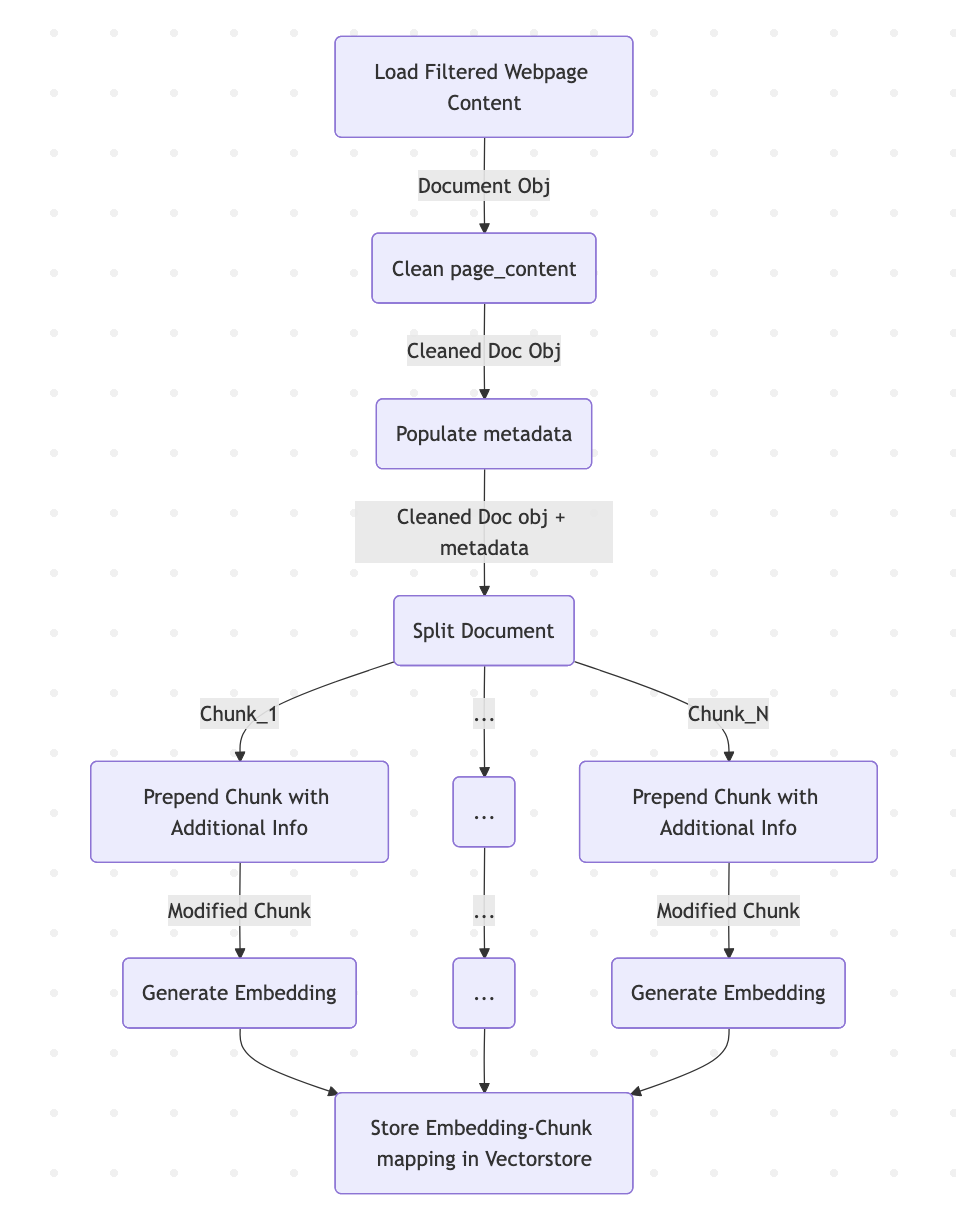

In [6]:
Image("../attachments/indexing-flowchart.png", width=800)

In [ ]:
from langchain_classic.document_loaders import WebBaseLoader
import re
from langchain_text_splitters.character import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
import bs4

## Generating Vectorstore

In [ ]:
class Indexing:
     
    def __init__(self, sources: list[str], embedding_model, chunk_size=4200, chunk_overlap=200):
        self._sources = sources
        self._chunk_size = chunk_size
        self._chunk_overlap = chunk_overlap
        self._text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len)
        self._embedding_model = embedding_model
        self._total_chunks = 0
    
    def _clean_page_content(self, document):
        """Clean video transcript and reference labels"""

        matches = re.findall('[0-9]{2}:[0-9]{2}: [0-9A-Za-z \'";.,!?-]*',document.page_content)

        if not matches:
            return document

        page_content = document.page_content
        idx1 = page_content.find(matches[0])
        idx2 = page_content.find(matches[-2]) + len(matches[-2])
        page_content = page_content[:idx1] + page_content[idx2:]
        page_content = re.sub(r'\[\d+\]','',page_content)
        page_content = re.sub('[0-9]{2}:[0-9]{2}: ','',page_content)
        document.page_content = page_content
        
        return document
    
    def _populate_metadata(self, document):

        """Add doc_id and doc_title and guide_type to metadata"""

        source = document.metadata.get('source')
        document.metadata['doc_id'] = self._sources.index(source)
        document.metadata['doc_title'] = " ".join(source.split("/")[-3].split("-"))
        document.metadata['guide_type'] = " ".join(source.split("/")[-4].split("-"))

        return document
    
    def _prepend_additional_info(self, document):
        
        """Prepend chunk page_content with parent doc_tile and guide_type"""

        doc_title = document.metadata.get('doc_title')
        guide_type = document.metadata.get('guide_type')
        document.page_content = f"Guide Type: {guide_type}\n\nDocument Title: {doc_title}\n\n" + document.page_content

        return document
    
    def generate_vectorstore(self):

        vectorstore = Chroma(
            embedding_function=self._embedding_model,
            collection_name='guides',
            persist_directory="../data/chroma_knowledge_base"
        )

        loader = WebBaseLoader( 
            web_paths= self._sources,
            bs_kwargs={
                "parse_only": bs4.SoupStrainer(id="content"), # filtering web data
            },
            bs_get_text_kwargs={"separator": " ", "strip": True},
        )

      
        for doc in loader.lazy_load():
            cleaned_doc = self._clean_page_content(doc)
            cleaned_doc_with_metadata = self._populate_metadata(cleaned_doc)
            chunks = list(map(self._prepend_additional_info, self._text_splitter.split_documents([cleaned_doc_with_metadata])))
            self._total_chunks += len(chunks)
            vectorstore.add_documents(chunks)
        
        return vectorstore

In [5]:
canvas_student_guide = [
    # Introduction
    'https://community.canvaslms.com/t5/Student-Guide/Student-Getting-Started-Resources/ta-p/579371',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-accept-an-email-invitation-to-join-a-Canvas-course/ta-p/1563',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-sign-up-for-a-Canvas-account-with-a-join-code-or-secret/ta-p/437',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-generate-a-pairing-code-for-an-observer-as-a-student/ta-p/418',
    # Announcements
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Announcements-as-a-student/ta-p/417',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-add-an-announcement-in-a-group/ta-p/458',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-edit-an-announcement-in-a-group/ta-p/459',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-delete-an-announcement-in-a-group/ta-p/457',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-add-an-external-RSS-feed-to-a-group-announcement-as-a/ta-p/449',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-subscribe-to-the-Announcements-RSS-feed-as-a-student/ta-p/448',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-reply-to-an-announcement-as-a-student/ta-p/447',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-like-a-reply-in-a-course-announcement-as-a-student/ta-p/344',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-or-reply-to-an-announcement-thread-as-a-student/ta-p/485667',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-mention-a-user-in-an-announcement-reply-as-a-student/ta-p/485670',
    'https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-announcements-as-a-student-in-Canvas-for/ta-p/645000',
    # Assignments
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Assignments-as-a-student/ta-p/451",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-the-rubric-for-my-assignment/ta-p/275",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-the-rubric-for-my-external-tool-assignment/ta-p/526",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-an-online-assignment/ta-p/503",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-text-entry-assignment/ta-p/303",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-enter-a-URL-as-an-assignment-submission/ta-p/286",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-media-file-as-an-assignment-submission/ta-p/279",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-Lucid-document-for-a-Lucid-assignment/ta-p/606359",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-an-assignment-on-behalf-of-a-group/ta-p/294",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-know-if-I-have-a-peer-review-assignment-to-complete/ta-p/318",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-peer-review-to-an-assignment/ta-p/293",
    "https://community.canvaslms.com/t5/Student-Guide/Where-can-I-find-my-peers-feedback-for-peer-reviewed-assignments/ta-p/320",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-upload-a-file-as-an-assignment-submission-in-Canvas/ta-p/274",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-my-webcam-to-take-a-photo-for-an-assignment/ta-p/452365",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-annotate-a-file-as-an-assignment-submission-in-Canvas/ta-p/463702",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-upload-a-file-from-Google-Drive-as-an-assignment/ta-p/499",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-Google-Assignments-LTI-1-3-file-as-an/ta-p/587649",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-cloud-assignment-with-Google-Drive/ta-p/491",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-upload-a-file-from-Microsoft-Office-365-as-an/ta-p/301",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-know-when-my-assignment-has-been-submitted/ta-p/277",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-know-when-my-instructor-has-graded-my-assignment/ta-p/276",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-cloud-assignment-with-Microsoft-Office-365/ta-p/299",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-assignment-comments-from-my-instructor/ta-p/283",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-DocViewer-in-Canvas-assignments-as-a-student/ta-p/525",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-annotation-feedback-comments-from-my-instructor/ta-p/523",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-rubric-results-for-my-assignment/ta-p/533",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-Roll-Call-Attendance-report-as-a-student/ta-p/354",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-download-assignment-submissions-from-all-my-courses/ta-p/298",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-an-online-assignment-in-Canvas-for-Elementary/ta-p/644996",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-assignment-feedback-from-my-instructor-in-Canvas/ta-p/645001",
    # Assignment Enhancements
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-an-assignment-in-a-course-using-Assignment/ta-p/416676",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-the-rubric-for-an-assignment-in-a-course-using/ta-p/416677",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-an-online-assignment-in-a-course-using/ta-p/416675",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-an-assignment-on-behalf-of-a-group-using/ta-p/481742",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-text-entry-assignment-in-a-course-using/ta-p/416667",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-upload-a-file-as-an-assignment-submission-for-a-course/ta-p/416664",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-annotate-a-file-as-an-assignment-submission-using/ta-p/478067",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-my-webcam-to-take-a-photo-for-an-assignment/ta-p/478066",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-media-file-as-an-assignment-submission-for-a/ta-p/416670",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-enter-a-URL-as-an-assignment-submission-for-a-course/ta-p/416672",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-Google-Drive-file-or-URL-as-an-assignment/ta-p/416665",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-Microsoft-Office-365-file-as-an-assignment/ta-p/416674",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-know-when-my-assignment-has-been-submitted-in-a-course/ta-p/416678",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-self-assessment-to-an-assignment-using/ta-p/637111",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-know-if-I-have-a-peer-review-assignment-to-complete/ta-p/566790",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-peer-review-to-an-assignment-using-Assignment/ta-p/566791",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-peer-review-to-an-assignment-using-Enhanced/ta-p/609350",
    "https://community.canvaslms.com/t5/Student-Guide/Where-can-I-find-my-peers-feedback-for-peer-reviewed-assignments/ta-p/566792",
    "https://community.canvaslms.com/t5/Student-Guide/Where-can-I-find-my-peers-feedback-for-peer-reviewed-assignments/ta-p/609351",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-assignment-feedback-from-my-instructor-using/ta-p/474046",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-DocViewer-in-Canvas-using-Assignment-Enhancements/ta-p/611848",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-an-online-assignment-in-Canvas-for-Elementary/ta-p/644994",
    # Chat
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-Chat-as-a-student/ta-p/315",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-inline-chat-as-a-student/ta-p/442",
    # Collaborations
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Collaborations-as-a-student/ta-p/413",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-Google-Docs-collaboration-as-a-student/ta-p/391",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-Google-Drive-collaboration-as-a-student/ta-p/389",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-Google-Assignments-LTI-1-3-collaboration-as-a/ta-p/587648",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-Microsoft-Office-365-collaboration-as-a/ta-p/390",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-delete-a-collaboration-as-a-student/ta-p/387",
    # Conferences
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-Conferences-in-a-course-as-a-student/ta-p/470",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-conference-in-a-student-group/ta-p/270",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-edit-or-delete-a-conference-in-a-student-group/ta-p/343",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-record-a-conference-in-a-student-group/ta-p/271",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-start-a-conference-in-a-student-group/ta-p/348",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-join-a-conference-in-a-course-as-a-student/ta-p/332",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-the-Conferences-interface-as-a-participant/ta-p/342",
    # Course Navigation
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-the-Course-Home-Page-as-a-student/ta-p/504",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-the-Course-Activity-Stream-as-a-student/ta-p/394",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-drop-a-self-enrolled-Canvas-course/ta-p/454",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-the-Syllabus-as-a-student/ta-p/439",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Course-Analytics-in-a-course-as-a-student/ta-p/450",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-the-Microsoft-Immersive-Reader-in-a-course-as-a/ta-p/446",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-my-Homeroom-as-a-student-in-Canvas-for-Elementary/ta-p/644992",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Important-Dates-as-a-student-in-Canvas-for/ta-p/644995",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-navigate-my-subject-as-a-student-in-Canvas-for/ta-p/644993",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-drop-a-self-enrolled-Canvas-for-Elementary-subject/ta-p/644997",
    # Discussions
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Discussions-as-a-student/ta-p/314",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-the-rubric-for-my-graded-discussion/ta-p/319",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-subscribe-to-a-discussion-podcast-as-a-student/ta-p/368",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-know-if-I-have-a-peer-review-discussion-to-complete/ta-p/419",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-peer-review-to-a-discussion/ta-p/355",
    "https://community.canvaslms.com/t5/Student-Guide/Where-can-I-find-my-peers-feedback-for-peer-reviewed-discussions/ta-p/428",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-course-discussion-as-a-student/ta-p/300",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-subscribe-to-a-discussion-as-a-student/ta-p/352",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-and-sort-discussion-replies-as-a-student/ta-p/465",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-change-discussion-settings-to-manually-mark-discussion/ta-p/366",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-mark-discussion-replies-as-read-or-unread-as-a-student/ta-p/284",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-reply-to-a-discussion-as-a-student/ta-p/334",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-attach-a-file-to-a-discussion-reply-as-a-student/ta-p/375",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-embed-an-image-in-a-discussion-reply-as-a-student/ta-p/313",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-edit-or-delete-discussion-replies-as-a-student/ta-p/399",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-like-a-reply-in-a-course-discussion-as-a-student/ta-p/392",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-a-discussion-thread-as-a-student/ta-p/485668",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-mention-a-user-in-a-discussion-reply-as-a-student/ta-p/485669",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-report-a-reply-in-a-discussion/ta-p/542169",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-reply-to-a-discussion-as-a-student-in-Canvas-for/ta-p/645002",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-translate-a-discussion-using-AI-Translations-as-a/ta-p/660442",
    # Grades
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-grades-in-a-current-course/ta-p/493",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-add-a-comment-to-a-submission-as-a-student/ta-p/606650",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-Learning-Mastery-scores-in-the-Grades-page/ta-p/477",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-the-icons-and-colors-in-the-Grades-page/ta-p/476",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-approximate-my-assignment-scores-using-the-What-If/ta-p/481",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-grades-in-a-concluded-course/ta-p/492",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-grades-in-a-current-subject-in-Canvas-for/ta-p/644998",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-Learning-Mastery-scores-for-a-subject-in-Canvas/ta-p/644999",
    # Modules
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Modules-as-a-student/ta-p/433",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-mark-a-module-item-as-done-for-a-module-requirement/ta-p/311",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-choose-an-assignment-path-in-a-module/ta-p/478",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-course-content-offline-as-an-HTML-file-as-a/ta-p/341",
    # Pages
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Pages-as-a-student/ta-p/371",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-new-page-in-a-group/ta-p/304",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-change-a-page-name-in-a-group/ta-p/362",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-edit-a-course-page-as-a-student/ta-p/479",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-edit-a-page-in-a-group/ta-p/487",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-delete-pages-in-a-group/ta-p/330",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-upload-a-PDF-to-a-page-in-a-group/ta-p/347",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-link-to-other-pages-in-a-group/ta-p/349",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-embed-media-in-a-page-in-a-group/ta-p/508",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-file-link-in-a-page-in-a-group/ta-p/510",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-the-history-of-a-page-in-a-group/ta-p/404",
    # People and Groups
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-the-People-page-in-a-course-as-a-student/ta-p/530",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-course-analytics-as-a-student/ta-p/312",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-all-groups-in-a-course-as-a-student/ta-p/353",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-Canvas-groups-as-a-student/ta-p/281",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-groups-as-a-student/ta-p/603040",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-join-a-group-as-a-student/ta-p/468",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-leave-a-group-as-a-student/ta-p/415",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-switch-groups-as-a-student/ta-p/601381",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-group-as-a-student/ta-p/280",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-upload-a-file-to-a-group/ta-p/278",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-start-a-collaboration-in-a-group-as-a-student/ta-p/438",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-create-a-discussion-in-a-group-as-a-student/ta-p/350",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-close-a-discussion-for-comments-in-a-group-as-a-student/ta-p/376",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-manage-groups-as-a-student-group-leader/ta-p/473",
    # Portfolios
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-use-Portfolios-as-a-student/ta-p/651576",
    # Quizzes
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-Quizzes-as-a-student/ta-p/472",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-the-rubric-for-a-quiz/ta-p/453",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-take-a-quiz/ta-p/507",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-take-a-quiz-in-New-Quizzes/ta-p/291",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-take-a-quiz-where-I-can-only-view-one-question-at-a/ta-p/482",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-take-a-quiz-where-I-can-only-view-one-question-at-a/ta-p/292",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-answer-each-type-of-question-in-a-quiz/ta-p/474",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-answer-each-type-of-question-in-New-Quizzes/ta-p/290",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-resume-a-quiz-that-I-already-started-taking/ta-p/452",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-quiz/ta-p/475",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-quiz-results-as-a-student/ta-p/335",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-quiz-comments-from-my-instructor/ta-p/471",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-view-my-quiz-results-as-a-student-in-New-Quizzes/ta-p/289",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-know-if-I-can-retake-a-quiz/ta-p/490",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-know-if-I-can-retake-a-quiz-in-New-Quizzes/ta-p/287",
    "https://community.canvaslms.com/t5/Student-Guide/How-do-I-submit-a-survey/ta-p/380",
]

In [6]:
canvas_basics_guide = [
    # General Information
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-Canvas/ta-p/45",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/Where-do-I-find-my-institution-s-URL-to-access-Canvas/ta-p/82",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-the-browser-and-computer-requirements-for-Instructure/ta-p/66",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-the-limited-support-guidelines-for-mobile-browsers-on/ta-p/389121",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-clear-my-browser-cache-and-cookies/ta-p/43",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/Can-I-repurpose-content-from-the-Guides-for-my-institution-s-use/ta-p/389122",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/Where-can-I-download-the-Guides-PDF-manuals/ta-p/389123",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-the-Canvas-accessibility-standards/ta-p/1564",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-reset-my-Canvas-password/ta-p/446128",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-allow-pop-ups-for-Canvas-in-my-browser/ta-p/33",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/Which-languages-does-Canvas-support/ta-p/19",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/Which-countries-are-restricted-from-using-Canvas/ta-p/27",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-does-Canvas-define-the-terms-used-to-describe-its-features/ta-p/51",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Admin-role/ta-p/78",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Designer-role/ta-p/14",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Teacher-role/ta-p/86",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Teacher-Assistant-role/ta-p/84",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Student-role/ta-p/71",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Observer-role/ta-p/4",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-term-dates-course-dates-and-section-dates-work-in-Canvas/ta-p/37",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-tools-and-computer-skills-do-I-need-to-use-Canvas/ta-p/446129",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-enable-third-party-cookies-in-my-browser/ta-p/605670",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-set-up-the-Lucid-Education-Suite-in-my-course/ta-p/618243",
    # Canvas Features
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-Course-Analytics/ta-p/73",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Announcements/ta-p/39",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Assignments/ta-p/9",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-Assignment-Enhancements/ta-p/416679",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Calendar/ta-p/76",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-Chat/ta-p/63",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Collaborations/ta-p/61",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Conferences/ta-p/53",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Course-Import-Tool/ta-p/21",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Discussions/ta-p/3",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Discussion-Summaries/ta-p/654034",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-DocViewer/ta-p/647614",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-ePortfolios/ta-p/1",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-External-Apps-LTI-Tools/ta-p/57",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Files/ta-p/7",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Grades-and-the-Gradebook/ta-p/49",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-grading-schemes/ta-p/41",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-What-If-Grades/ta-p/25",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Groups/ta-p/16",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Inbox/ta-p/55",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Mastery-Paths/ta-p/404483",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Modules/ta-p/6",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Outcomes/ta-p/75",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Pages/ta-p/5",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Peer-Reviews/ta-p/615313",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Profile-Settings/ta-p/15",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-question-banks/ta-p/23",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Quizzes/ta-p/68",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-New-Quizzes/ta-p/17",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Rich-Content-Editor-RCE/ta-p/12",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Roll-Call-Attendance-Tool/ta-p/59",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Rubrics/ta-p/35",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Scheduler/ta-p/11",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-SIS-Imports/ta-p/47",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-Smart-Search/ta-p/652958",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-SpeedGrader/ta-p/13",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-User-Settings/ta-p/647506",
    # Canvas Help
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Canvas-Welcome-Tour/ta-p/618756",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Training-Services-Portal/ta-p/618752",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-get-help-with-Canvas/ta-p/618758",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-contact-Canvas-Support/ta-p/389767",
    # Canvas Mobile
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-can-I-use-Canvas-on-my-mobile-device/ta-p/615335",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-access-Canvas-using-a-mobile-browser-on-my-Android/ta-p/65",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-access-Canvas-using-a-mobile-browser-on-my-iOS-device/ta-p/8",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Canvas-Student-app/ta-p/31",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Canvas-Teacher-app/ta-p/69",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Canvas-Parent-app/ta-p/10",
    # Calendar
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Calendar/ta-p/617613",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-an-event-to-my-personal-calendar/ta-p/617612",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-an-event-to-a-course-calendar/ta-p/617610",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-an-assignment-from-the-Calendar/ta-p/617606",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-a-to-do-item-in-the-Calendar/ta-p/617599",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-a-recurring-event-in-a-calendar/ta-p/617604",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-edit-or-delete-an-event-or-assignment-in-the-Calendar/ta-p/617605",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-filter-the-Calendar-view-by-course/ta-p/617609",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-set-a-different-event-date-for-each-section-in-a-course/ta-p/617603",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-and-duplicate-an-event-for-course-sections-in-the/ta-p/617611",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-subscribe-to-the-Calendar-feed-using-Google-Calendar/ta-p/617614",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-an-appointment-group-in-a-course-calendar/ta-p/617602",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-or-edit-an-appointment-group-in-a-course-calendar/ta-p/617608",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-sign-up-for-an-appointment-in-the-Calendar/ta-p/617615",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-subscribe-to-the-Calendar-feed-using-Outlook-com/ta-p/617601",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-a-group-calendar/ta-p/617600",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-and-manage-Account-Calendars/ta-p/617598",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-the-Calendar-iCal-feed-to-subscribe-to-an-external/ta-p/617607",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-an-event-to-the-schedule-in-Canvas-for-Elementary/ta-p/644985",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-mark-an-assignment-or-calendar-event-with-an-important/ta-p/644976",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-my-schedule-as-a-student-in-Canvas-for-Elementary/ta-p/644981",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-the-schedule-for-a-student-as-an-observer-in/ta-p/644984",
    # Dashboard
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Dashboard-as-a-student/ta-p/618762",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Dashboard-as-an-instructor/ta-p/618754",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Dashboard-as-an-observer/ta-p/618747",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-my-courses-in-the-Card-View-Dashboard/ta-p/618765",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-grades-for-all-courses-in-the-Card-View-Dashboard/ta-p/618748",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-global-activity-for-all-courses-in-the-Recent/ta-p/618764",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-To-Do-list-and-sidebar-in-the-Dashboard-as-a/ta-p/618761",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-To-Do-list-for-all-my-courses-in-the-List-View/ta-p/618751",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-a-To-Do-item-in-the-List-View-Dashboard-as-a/ta-p/618755",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-To-Do-list-and-sidebar-in-the-Dashboard-as-an/ta-p/618753",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-share-feedback-using-Instructure-s-Net-Promoter-Score/ta-p/646731",
    # ePortfolios
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-a-new-ePortfolio/ta-p/616171",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-ePortfolio-Getting-Started-Wizard/ta-p/616178",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-organize-my-ePortfolio/ta-p/616177",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-a-new-ePortfolio-section/ta-p/616175",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-organize-my-ePortfolio-pages/ta-p/616176",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-edit-the-default-page-in-my-ePortfolio-section/ta-p/616172",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-a-new-page-in-my-ePortfolio-section/ta-p/616173",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-preview-a-page-in-my-ePortfolio/ta-p/616179",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-rich-text-content-to-my-ePortfolio-page/ta-p/616181",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-HTML-embedded-content-to-my-ePortfolio-page/ta-p/616165",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-retrieve-assignments-from-previous-courses-in-my/ta-p/616167",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-upload-a-file-or-image-to-my-ePortfolio-page/ta-p/616168",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-enable-comments-in-my-ePortfolio/ta-p/616166",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-download-the-contents-of-my-ePortfolio/ta-p/616170",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-can-I-share-a-private-ePortfolio/ta-p/616169",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-make-my-ePortfolio-public/ta-p/616174",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-delete-my-ePortfolio/ta-p/616180",
    # Files
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-Files/ta-p/617201",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-course-files/ta-p/617226",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-group-files/ta-p/617203",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-my-user-files/ta-p/617227",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-preview-a-file-in-Files/ta-p/617193",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-move-and-organize-files/ta-p/617197",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-a-folder-in-Files/ta-p/617206",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-delete-a-file-or-folder-in-Files/ta-p/617196",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-download-a-file-or-folder/ta-p/617195",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-edit-a-file-in-Files/ta-p/617205",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-rename-a-file-or-folder/ta-p/617200",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-restrict-files-and-folders/ta-p/617189",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-set-usage-rights-and-user-access-for-a-file-or-folder/ta-p/617208",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-upload-a-file-in-Files/ta-p/617194",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-upload-ZIP-files-in-Files/ta-p/617192",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-bulk-upload-files/ta-p/617198",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-my-Google-Drive-files-in-Canvas/ta-p/617188",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-my-Microsoft-Office-365-files-in-Canvas/ta-p/617186",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-types-of-files-can-I-preview-in-Canvas/ta-p/617187",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-types-of-media-files-can-I-upload-in-Canvas/ta-p/617185",
    # Global Navigation
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-log-in-to-Canvas/ta-p/618760",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Global-Navigation-Menu/ta-p/618767",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-the-Global-Announcements-page/ta-p/618749",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-my-recent-page-view-history-in-Canvas/ta-p/618750",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-log-out-of-Canvas/ta-p/618763",
    # Inbox
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Inbox/ta-p/616671",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-send-a-message-to-a-user-in-a-course-in-the-Inbox/ta-p/616669",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-send-a-message-to-all-course-users-in-the-Inbox/ta-p/616659",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-find-my-unread-messages-in-the-Inbox/ta-p/616660",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-send-a-message-to-a-user-in-a-student-group-in-the/ta-p/616657",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-attach-a-file-to-a-message-in-the-Inbox/ta-p/616658",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-record-or-upload-media-to-a-message-in-the-Inbox/ta-p/616664",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-reply-to-a-message-in-the-Inbox/ta-p/616662",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-privately-reply-to-one-individual-in-a-group-message-in/ta-p/616663",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-reply-to-submission-comments-in-the-Inbox/ta-p/616667",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-forward-a-message-from-a-conversation-in-the-Inbox/ta-p/616668",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-delete-a-message-from-a-conversation-in-the-Inbox/ta-p/616665",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-archive-a-conversation-in-the-Inbox/ta-p/616677",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-new-people-to-an-existing-conversation-in-the-Inbox/ta-p/616670",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-delete-a-conversation-in-the-Inbox/ta-p/616672",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-filter-conversations-in-the-Inbox/ta-p/616656",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-star-a-conversation-in-the-Inbox/ta-p/616655",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-manage-my-Inbox-settings/ta-p/616661",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-Differentiated-Tags-in-the-Inbox-as-an-instructor/ta-p/657552",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-translate-an-Inbox-Message-using-AI-Translations/ta-p/660445",
    # Profile and User Settings
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-a-profile-picture-in-my-user-account/ta-p/615332",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-contact-methods-to-receive-Canvas-notifications/ta-p/615331",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-an-additional-email-address-as-a-contact-method-in/ta-p/615316",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-a-text-SMS-contact-method-in-Canvas/ta-p/615315",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-change-my-default-email-address-in-my-user-account/ta-p/615314",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-change-my-login-password-in-my-user-account/ta-p/615323",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-change-the-settings-in-my-user-account/ta-p/615322",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-edit-my-profile-in-my-user-account/ta-p/615501",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-change-the-language-preference-in-my-user-account/ta-p/615328",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-manage-my-Canvas-notification-settings/ta-p/615326",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-course-content-offline-as-an-ePub-file/ta-p/615317",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-set-a-time-zone-in-my-user-account/ta-p/615318",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-merge-my-user-account-with-an-account-using-the-same/ta-p/615319",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-manage-feature-options-in-my-user-account/ta-p/615327",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-feature-options-can-I-enable-in-my-user-account/ta-p/615324",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-set-up-multi-factor-authentication-for-my-user-account/ta-p/615333",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-manage-API-access-tokens-in-my-user-account/ta-p/615312",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-Slack-as-a-contact-method-in-Canvas/ta-p/615329",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-select-personal-pronouns-in-my-user-account/ta-p/615336",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-a-QR-code-to-log-in-to-the-Canvas-mobile-apps/ta-p/615320",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-manage-notifications-for-a-single-course/ta-p/615325",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-enable-the-high-contrast-user-interface-in-Canvas/ta-p/615334",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-manage-confetti-animations-in-Canvas/ta-p/615330",
    # Rich Content Editor (RCE)
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-access-the-Rich-Content-Editor/ta-p/618248",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-and-modify-text-in-the-Rich-Content-Editor/ta-p/618221",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-menubar-in-the-Rich-Content-Editor/ta-p/618230",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-insert-a-table-using-the-Rich-Content-Editor/ta-p/618220",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-HTML-view-in-the-Rich-Content-Editor/ta-p/618225",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-resize-the-Rich-Content-Editor/ta-p/618246",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-hyperlinks-to-external-URLs-in-the-Rich-Content/ta-p/618224",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-hyperlinks-to-user-group-or-course-files-in-the/ta-p/618223",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-hyperlinks-to-course-or-group-content-in-the/ta-p/618247",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-edit-or-remove-hyperlinks-in-the-Rich-Content-Editor/ta-p/618222",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-upload-and-embed-an-image-in-the-Rich-Content-Editor/ta-p/618228",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-embed-images-from-Canvas-into-the-Rich-Content-Editor/ta-p/618227",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-upload-and-embed-a-media-file-from-my-computer-in-the/ta-p/618237",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-manage-alt-text-and-display-options-for-images-embedded/ta-p/618226",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-upload-a-document-in-the-Rich-Content-Editor/ta-p/618233",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-embed-a-file-from-Google-Drive-into-the-Rich-Content/ta-p/618241",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-a-hyperlink-from-Microsoft-Office-365-in-the/ta-p/618240",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-link-to-or-embed-a-YouTube-video-in-the-Rich-Content/ta-p/618239",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-embed-media-files-from-Canvas-into-the-Rich-Content/ta-p/618242",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-link-to-a-document-from-Canvas-in-the-Rich-Content/ta-p/618244",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-math-Equation-Editor-in-the-Rich-Content-Editor/ta-p/618231",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-record-media-using-the-Rich-Content-Editor/ta-p/618235",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-add-captions-to-new-or-uploaded-videos-in-the-Rich/ta-p/618250",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-view-captions-in-a-video-in-the-Rich-Content-Editor/ta-p/618249",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-manage-video-options-in-the-Rich-Content-Editor/ta-p/618218",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-select-content-from-an-external-app-in-the-Rich-Content/ta-p/618219",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-embed-media-from-an-external-source-in-the-Rich-Content/ta-p/618217",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-embed-a-Lucid-document-in-the-Rich-Content-Editor/ta-p/618229",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-use-the-Accessibility-Checker-in-the-Rich-Content/ta-p/618238",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-create-an-icon-using-the-Rich-Content-Editor-Icon-Maker/ta-p/618234",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-edit-an-icon-made-using-the-Rich-Content-Editor-Icon/ta-p/618236",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-delete-an-icon-made-using-the-Rich-Content-Editor-Icon/ta-p/618232",
    # Web Services
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-connect-to-web-services-outside-of-Canvas/ta-p/617184",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-connect-to-Google-Drive-as-a-web-service-in-Canvas/ta-p/617183",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/How-do-I-connect-to-Skype-as-a-web-service-in-Canvas/ta-p/617190",
    # Canvas for Elementary
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/Canvas-for-Elementary-FAQ/ta-p/644982",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-Canvas-for-Elementary/ta-p/644983",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Homeroom-in-Canvas-for-Elementary/ta-p/644980",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-a-subject-in-Canvas-for-Elementary/ta-p/644978",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-is-the-Schedule-in-Canvas-for-Elementary/ta-p/644977",
    "https://community.canvaslms.com/t5/Canvas-Basics-Guide/What-are-Important-Dates-in-Canvas-for-Elementary/ta-p/644979",
]

In [7]:
canvas_troubleshooting_guide = [
    # Instructor
    "https://community.canvaslms.com/t5/Troubleshooting/Accessing-Canvas-assignments/ta-p/867",
    "https://community.canvaslms.com/t5/Troubleshooting/Making-assignments-available-to-students/ta-p/883",
    "https://community.canvaslms.com/t5/Troubleshooting/Making-files-available-to-students/ta-p/837",
    "https://community.canvaslms.com/t5/Troubleshooting/Managing-group-assignment-settings/ta-p/827",
    "https://community.canvaslms.com/t5/Troubleshooting/Viewing-icons-instead-of-quiz-scores-in-the-Gradebook/ta-p/847",
    "https://community.canvaslms.com/t5/Troubleshooting/Printing-quizzes-from-Canvas/ta-p/841",
    "https://community.canvaslms.com/t5/Troubleshooting/Viewing-quizzes-that-show-no-points-in-the-Gradebook/ta-p/843",
    "https://community.canvaslms.com/t5/Troubleshooting/Updating-a-Canvas-quiz/ta-p/829",
    "https://community.canvaslms.com/t5/Troubleshooting/Using-an-external-tool-in-my-course/ta-p/849",
    "https://community.canvaslms.com/t5/Troubleshooting/Using-the-Canvas-Gradebook/ta-p/881",
    "https://community.canvaslms.com/t5/Troubleshooting/Viewing-my-student-s-assignment-score/ta-p/869",
    "https://community.canvaslms.com/t5/Troubleshooting/Verifying-student-submissions/ta-p/851",
    # Student
    "https://community.canvaslms.com/t5/Troubleshooting/Accessing-Kaltura-videos/ta-p/839",
    "https://community.canvaslms.com/t5/Troubleshooting/Accessing-my-assignments/ta-p/833",
    "https://community.canvaslms.com/t5/Troubleshooting/Joining-a-Zoom-meeting/ta-p/865",
    "https://community.canvaslms.com/t5/Troubleshooting/Logging-into-Canvas/ta-p/875",
    "https://community.canvaslms.com/t5/Troubleshooting/Removing-a-course-from-my-dashboard/ta-p/835",
    "https://community.canvaslms.com/t5/Troubleshooting/Submitting-a-Canvas-assignment/ta-p/871",
    "https://community.canvaslms.com/t5/Troubleshooting/Submitting-a-quiz/ta-p/859",
    "https://community.canvaslms.com/t5/Troubleshooting/Updating-my-displayed-name-in-Canvas/ta-p/853",
    "https://community.canvaslms.com/t5/Troubleshooting/Viewing-Canvas-courses-in-the-Dashboard/ta-p/845",
    "https://community.canvaslms.com/t5/Troubleshooting/Viewing-my-courses-in-the-Canvas-Student-app/ta-p/879",
    "https://community.canvaslms.com/t5/Troubleshooting/Viewing-my-personal-to-do-items-in-the-Canvas-Student-app/ta-p/877",
    # Admin
    "https://community.canvaslms.com/t5/Troubleshooting/Changing-SIS-IDs/ta-p/821",
    "https://community.canvaslms.com/t5/Troubleshooting/Restoring-Canvas-course-content/ta-p/823",
    "https://community.canvaslms.com/t5/Troubleshooting/Restoring-missing-enrollments/ta-p/873",
    # All Users
    "https://community.canvaslms.com/t5/Troubleshooting/Logging-into-a-Free-for-Teacher-account/ta-p/857",
    "https://community.canvaslms.com/t5/Troubleshooting/Viewing-media-in-the-Rich-Content-Editor/ta-p/463739",
    "https://community.canvaslms.com/t5/Troubleshooting/Using-function-keys-on-my-Chromebook/ta-p/446131",
]

In [8]:
canvas_instructor_guide = [
# Announcements
  "https://community.canvaslms.com/t5/Instructor-Guide/How-do-I-allow-students-to-like-replies-in-a-course-announcement/ta-p/1220",
  
# Assignments
  "https://community.canvaslms.com/t5/Instructor-Guide/Can-a-student-resubmit-Canvas-assignments/ta-p/647",
 
# Discussions
  "https://community.canvaslms.com/t5/Instructor-Guide/How-do-I-allow-students-to-create-a-course-discussion/ta-p/996",
  "https://community.canvaslms.com/t5/Instructor-Guide/How-do-I-allow-students-to-attach-files-to-a-course-discussion/ta-p/874",
  "https://community.canvaslms.com/t5/Instructor-Guide/How-do-I-allow-students-to-edit-and-delete-their-own-discussion/ta-p/836",

# Quizzes
  "https://community.canvaslms.com/t5/Instructor-Guide/How-do-I-view-a-quiz-log-for-a-student/ta-p/580",

# Settings
  "https://community.canvaslms.com/t5/Instructor-Guide/How-do-I-restrict-student-access-to-a-course-before-or-after-the/ta-p/1269",
  
]

In [9]:
! ollama list

NAME                       ID              SIZE      MODIFIED    
bge-m3:latest              790764642607    1.2 GB    3 days ago     
embeddinggemma:latest      85462619ee72    621 MB    4 days ago     
nomic-embed-text:latest    0a109f422b47    274 MB    11 days ago    
gpt-oss:20b                17052f91a42e    13 GB     11 days ago    


In [3]:
emb_model = OllamaEmbeddings(model="bge-m3:latest", num_thread=4)

In [11]:
indexer = Indexing(sources=canvas_student_guide+canvas_basics_guide+canvas_troubleshooting_guide+canvas_instructor_guide, embedding_model=emb_model)

In [ ]:
indexer.generate_vectorstore()

In [ ]:
# 29 min build time

In [13]:
indexer._total_chunks

531

In [14]:
len(indexer._sources)

432

### Testing

In [4]:
knowledge_base = Chroma(
    embedding_function=emb_model,
    collection_name='guides',
    persist_directory="../data/chroma_knowledge_base"
)

In [19]:
knowledge_base.as_retriever().invoke("""I have registered to Introduction to Cyber Security course which is about to start tommorow, but the course is not visible in my canvas dashboard. I have approached IT Support but they were not able assist.""")

[Document(id='53829654-0ab1-4241-96e9-5843b41c1cec', metadata={'source': 'https://community.canvaslms.com/t5/Troubleshooting/Viewing-my-courses-in-the-Canvas-Student-app/ta-p/879', 'doc_title': 'Viewing my courses in the Canvas Student app', 'guide_type': 'Troubleshooting', 'doc_id': 417}, page_content='Guide Type: Troubleshooting\n\nDocument Title: Viewing my courses in the Canvas Student app\n\nViewing my courses in the Canvas Student app If you cannot view your courses in the Canvas Student app, you may need to select favorite courses in your Canvas browser. Note: The Canvas Student app for iOS devices only displays active courses. Active courses are courses that are published and that are accessed within the course participation dates. View App Without Course Cards If you have not selected any favorite courses, or if you have no active courses, your Canvas Student app dashboard may not display any course cards. Open Courses List In your Canvas browser, click the Global Navigation C

In [20]:
knowledge_base.as_retriever().invoke("""コース登録した授業のダッシュボードを消すにはどうすればいいですか？""")


[Document(id='6d0f71ce-f2a6-4d8f-ae49-6411f6cc9456', metadata={'doc_id': 412, 'guide_type': 'Troubleshooting', 'doc_title': 'Removing a course from my dashboard', 'source': 'https://community.canvaslms.com/t5/Troubleshooting/Removing-a-course-from-my-dashboard/ta-p/835'}, page_content='Guide Type: Troubleshooting\n\nDocument Title: Removing a course from my dashboard\n\nRemoving a course from my dashboard Your Canvas Dashboard displays both active and favorited courses. Active courses are courses that are published and that are within the course start and end dates. Favorited courses are courses you have starred. Additionally, if you have dropped a course, it may take up to 24 hours for your enrollment status to update in Canvas. If a dropped course still displays in your Dashboard after this time, you should confirm with your institution that you are fully dropped from the course. Open Courses List In Global Navigation, click the Courses link [1]. Then click the All Courses link [2]. 

### Visualize Embeddings in Vector Space

In [ ]:
! pip3 install nomic

In [ ]:
# ! nomic login "NOMIC-API-KEY"

In [26]:
from nomic import AtlasDataset

In [ ]:
dataset = AtlasDataset('canvas_guides')

In [28]:
embeddings = knowledge_base.get(include=['metadatas', 'embeddings'])['embeddings']

In [29]:
metadata = knowledge_base.get(include=['metadatas', 'embeddings'])['metadatas']

In [30]:
from nomic.data_inference import NomicTopicOptions
from nomic.data_inference import ProjectionOptions

In [ ]:
dataset.add_data(
    embeddings=embeddings, 
    data=metadata # Optional metadata for each embedding
)

In [ ]:
atlas_map = dataset.create_index(
    projection=ProjectionOptions( # projection quality is highly dependent on these options, finding the right combination may take some experimentation
        model="umap",
        n_neighbors=5, # lower values tend to create more local structure, higher values more global structure
        min_dist=0.05,
        n_epochs=50
    )
)

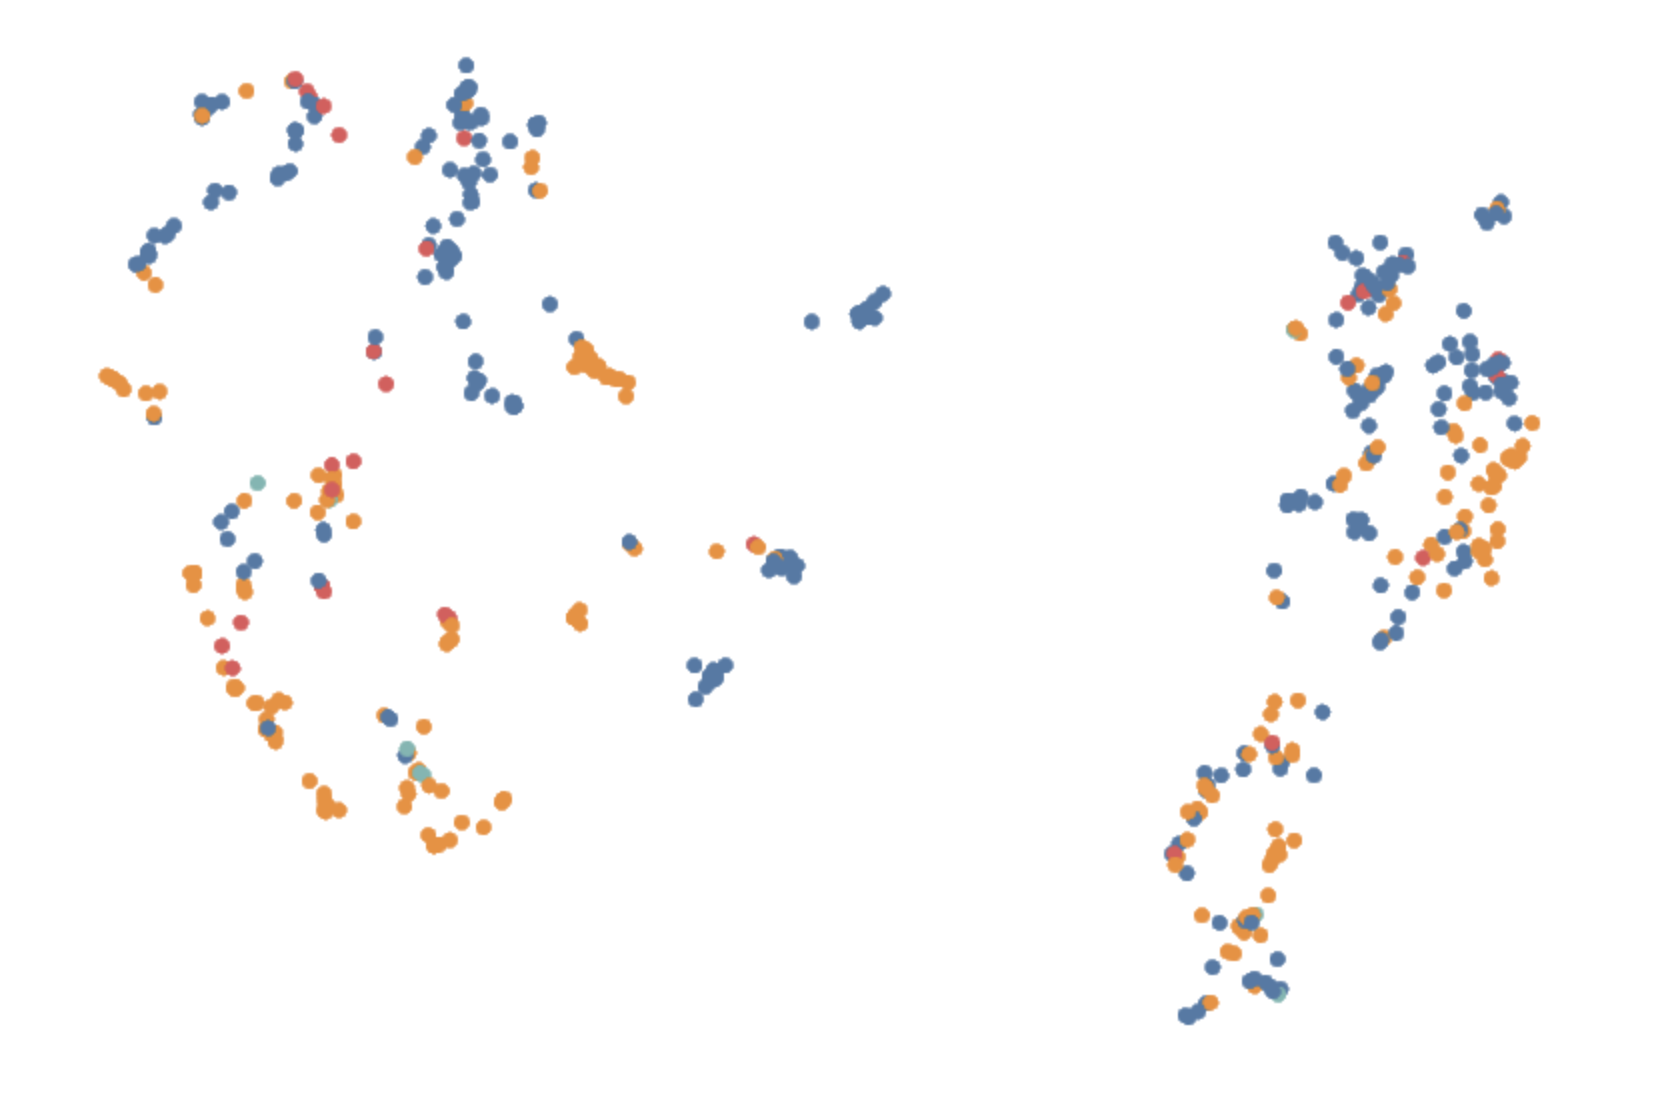

In [7]:
Image("../attachments/visualizing-embeddings/n_neighbours_5.png", width=700) # color coded by guide type i.e. basics, student, troubleshooting, instructor

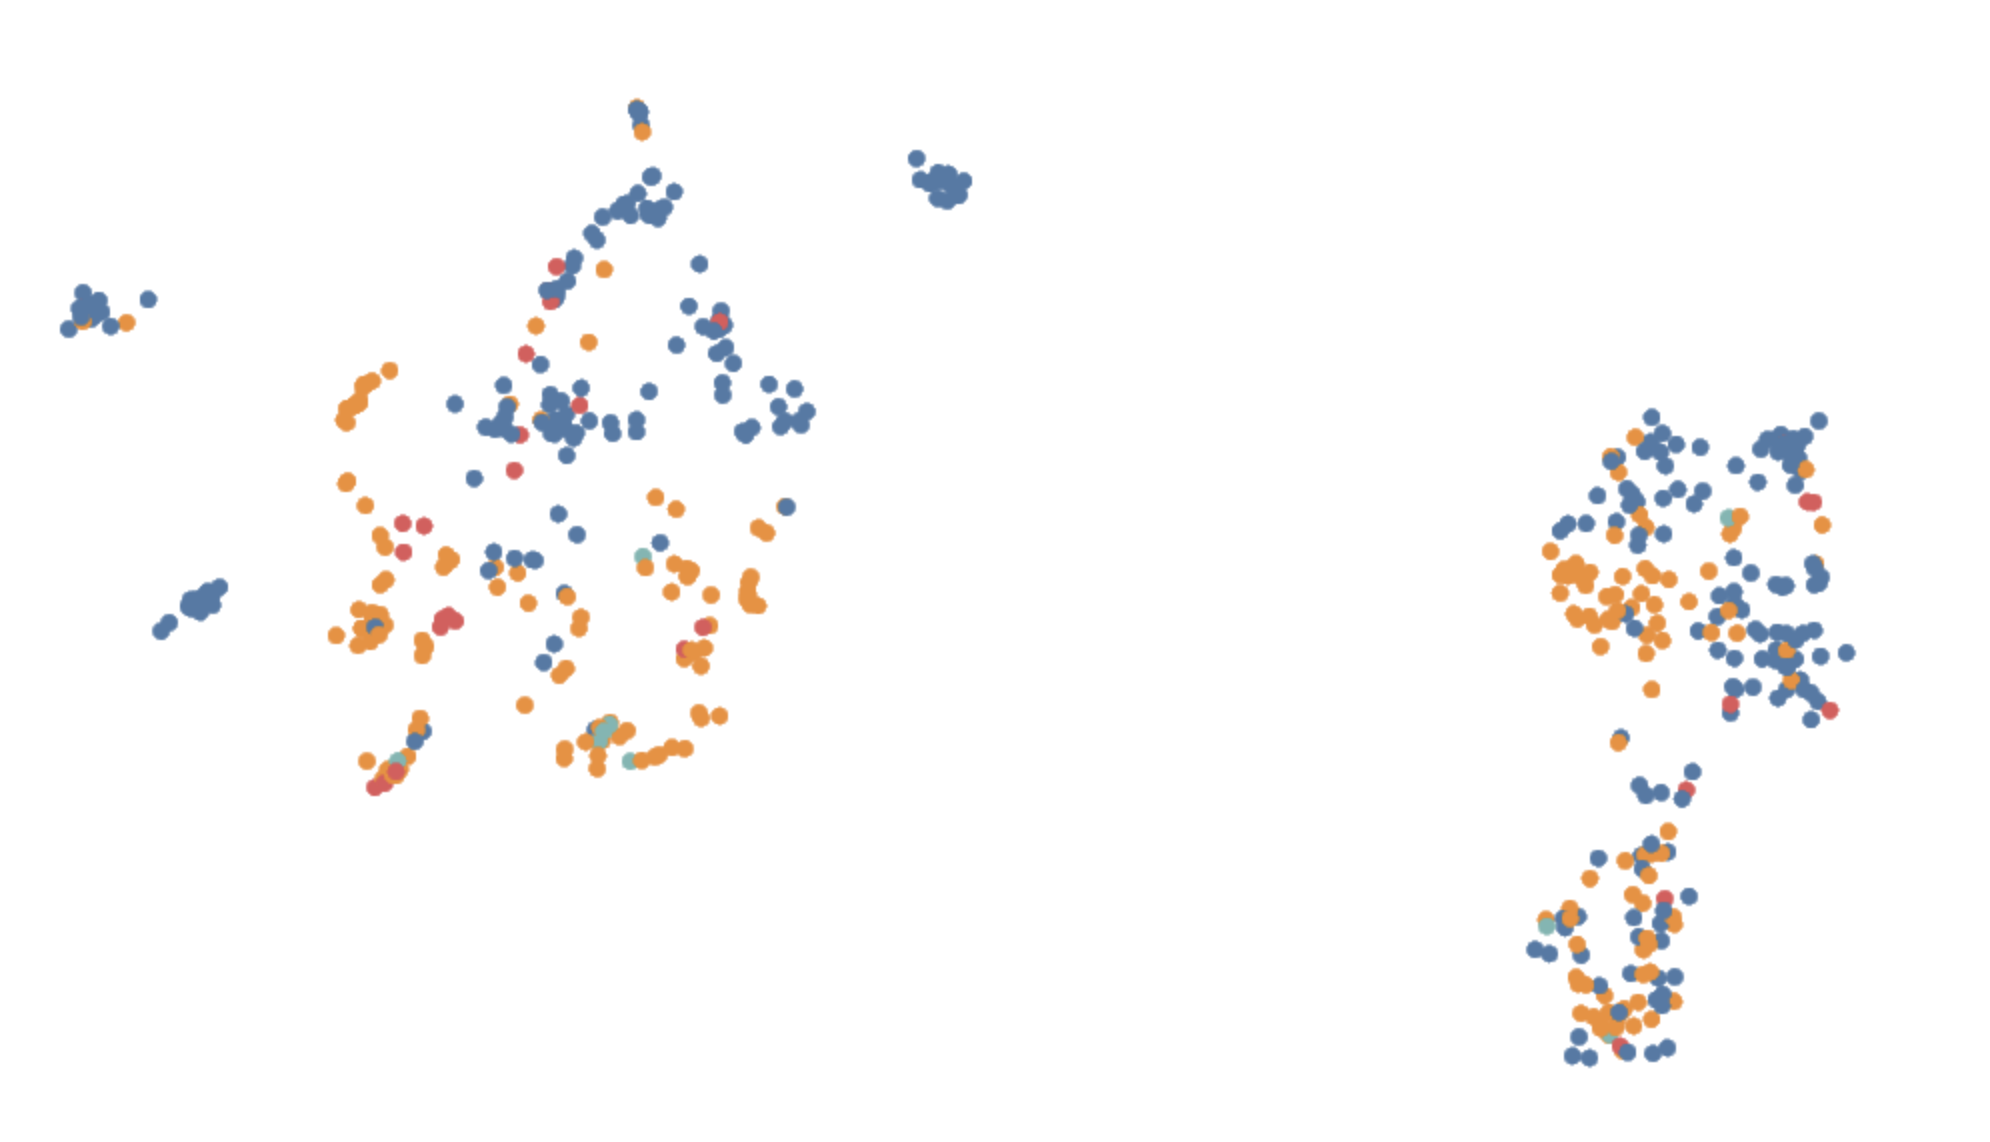

In [8]:
Image("../attachments/visualizing-embeddings/n_neighbours_10.png", width=700) # color coded by guide type i.e. basics, student, troubleshooting, instructor

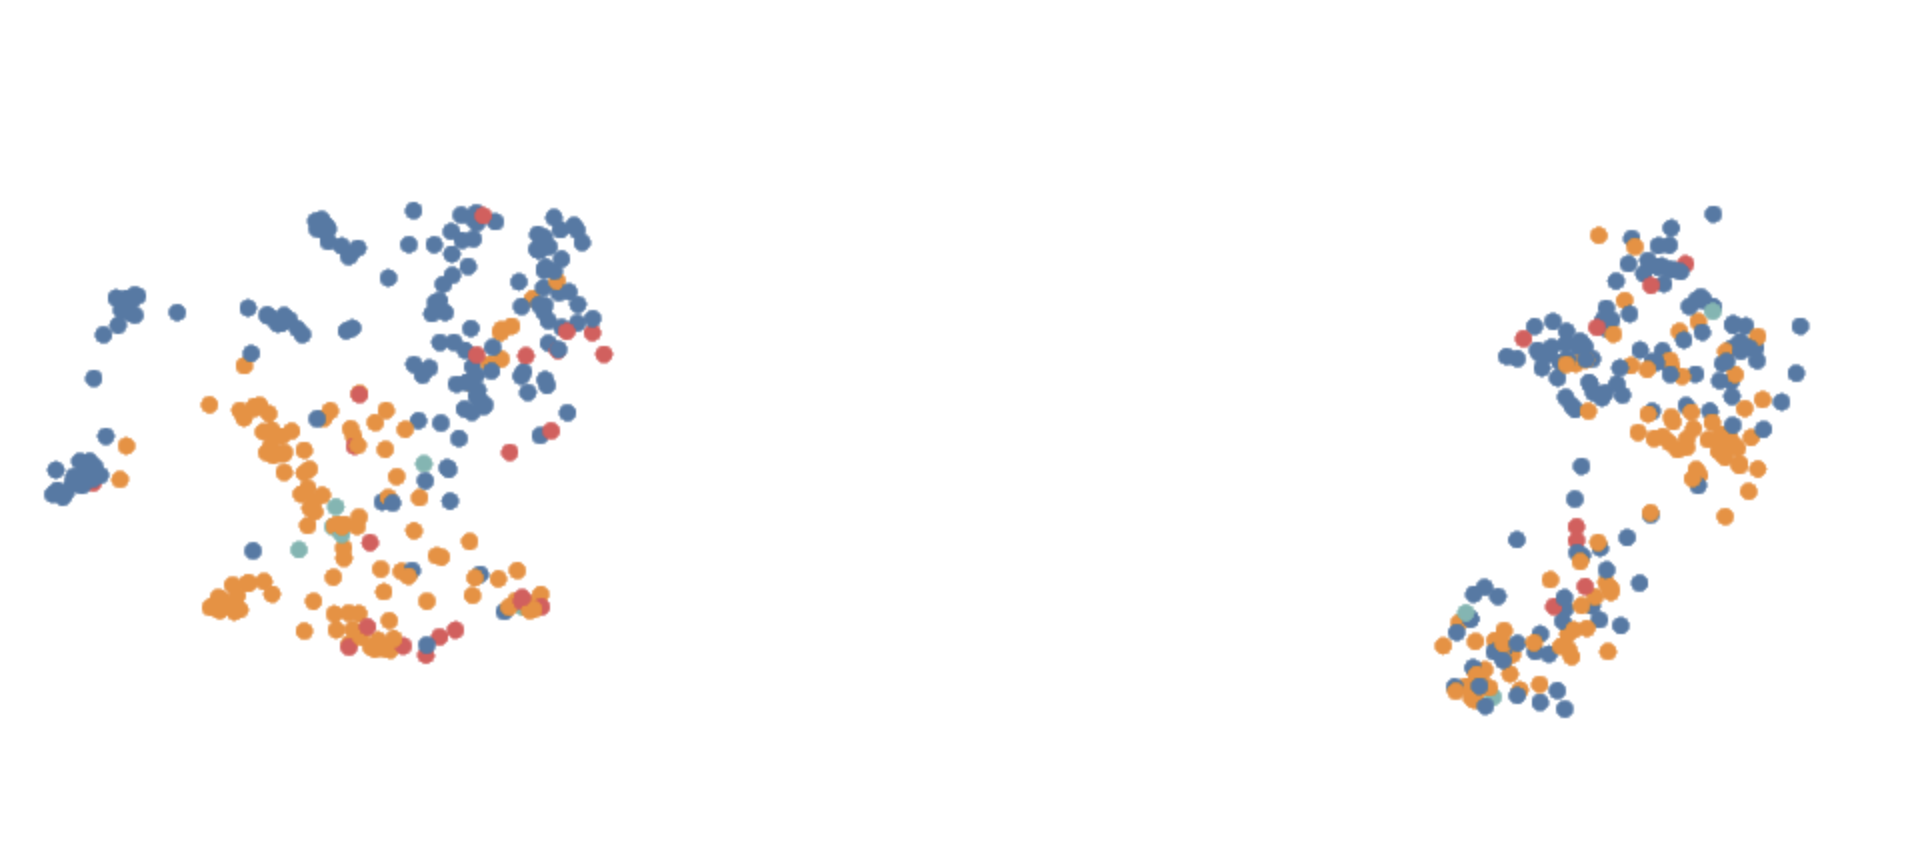

In [9]:
Image("../attachments/visualizing-embeddings/n_neighbours_20.png", width=700) # color coded by guide type i.e. basics, student, troubleshooting, instructor

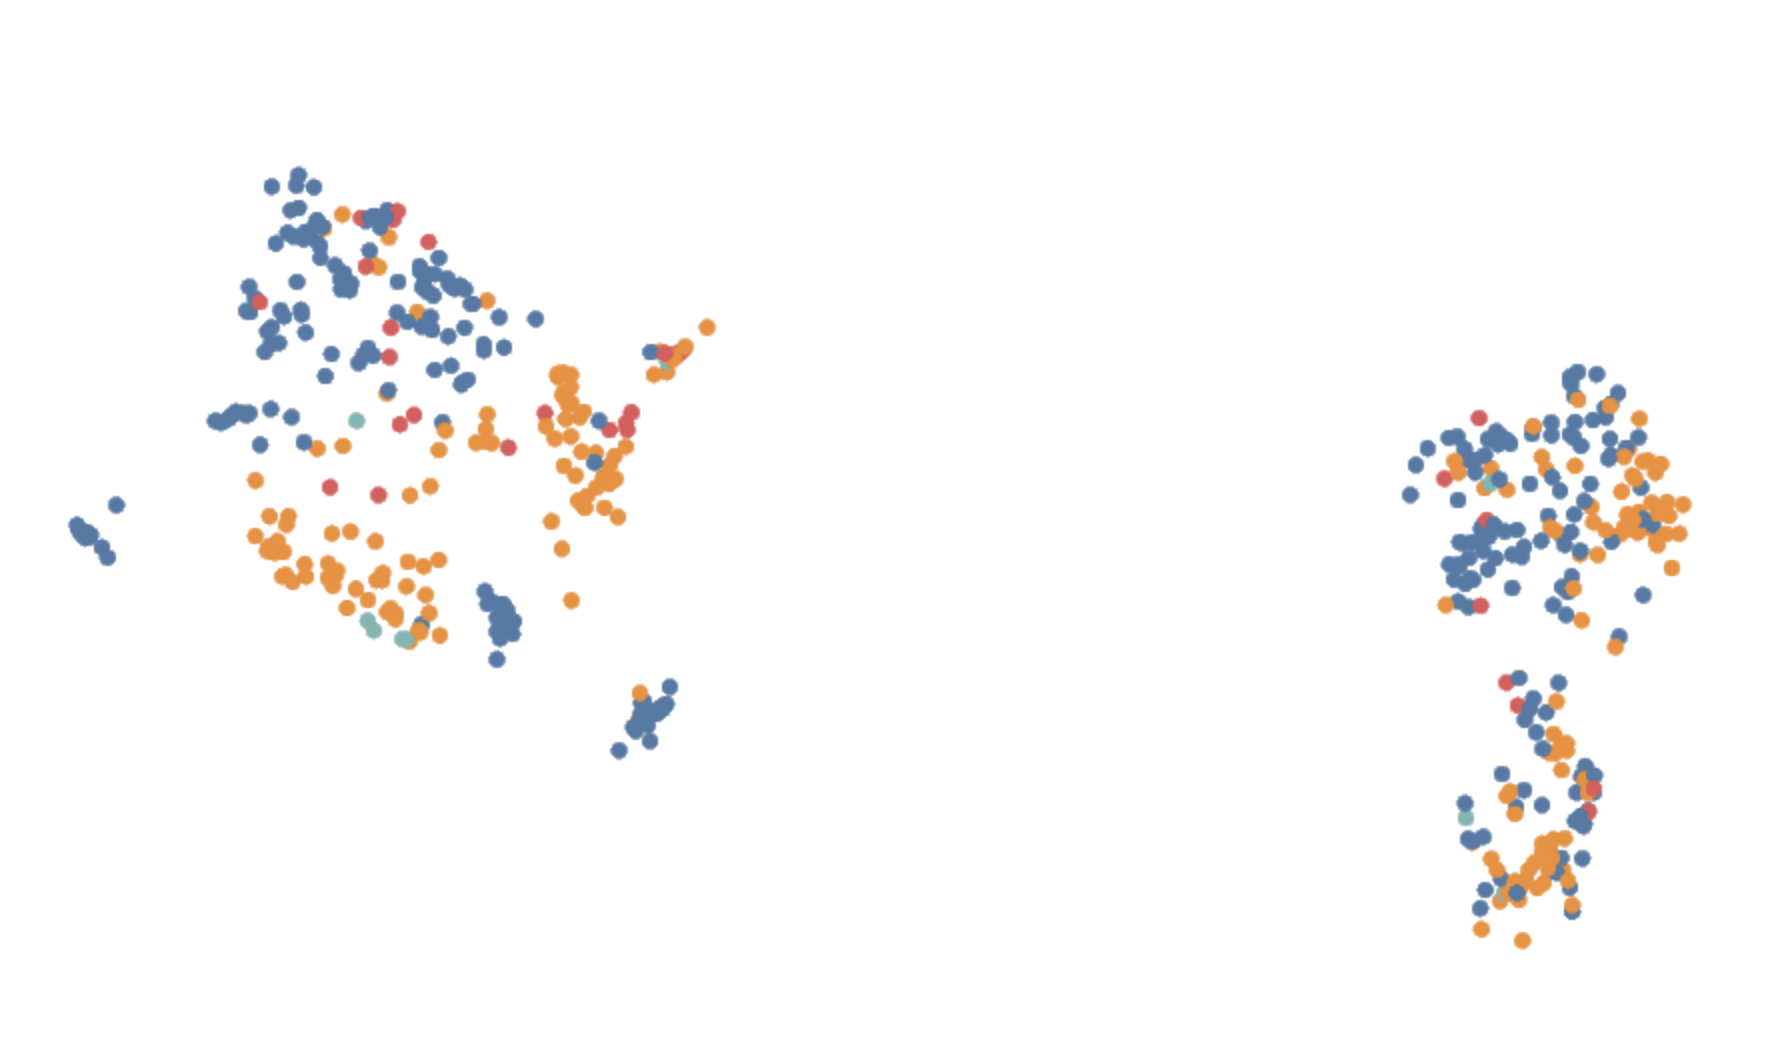

In [10]:
Image("../attachments/visualizing-embeddings/n_neighbours_25.png", width=700) # color coded by guide type i.e. basics, student, troubleshooting, instructor